# Financial timeseries data

In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pandas_datareader import DataReader
from scipy.stats import skew, kurtosis, shapiro

In [2]:
itau = DataReader('ITSA4.SA','yahoo', datetime(2000, 1, 1), datetime(2019,6, 30))
itau = itau.sort_values(by='Date')

In [3]:
itau.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-06-24,12.72,12.56,12.62,12.65,23706900.0,12.013014
2019-06-25,12.73,12.48,12.62,12.58,48985900.0,11.946539
2019-06-26,13.00,12.63,12.63,12.98,91411400.0,12.326397
2019-06-27,13.07,12.75,12.85,12.94,27201500.0,12.288410
2019-06-28,13.06,12.88,13.06,12.89,17982400.0,12.240929


## Calculating financial returns 

The file loaded included daily Open, High, Low, Close, Adjusted Close, and Volume data, often referred to as OHLCV data.

The Adjusted Close column is the most important. It is normalized for stock splits, dividends, and other corporate actions, and is a true reflection of the return of the stock over time. We will be using the adjusted close price to calculate the returns of the stock in this exercise.

In [4]:
itau['Returns'] = itau['Adj Close'].pct_change()
print(itau.head())

               High      Low     Open    Close      Volume  Adj Close  \
Date                                                                    
2000-01-03  1.14360  1.01290  1.01835  1.08370  10285107.0   0.620248   
2000-01-04  1.04558  0.98023  1.04558  0.98023  12071740.0   0.561028   
2000-01-05  1.06192  0.94756  0.98568  1.06192   9163033.0   0.607783   
2000-01-06  1.08370  1.05102  1.05647  1.07825  23085841.0   0.617129   
2000-01-07  1.10548  1.06192  1.08914  1.07281  11216095.0   0.614016   

             Returns  
Date                  
2000-01-03       NaN  
2000-01-04 -0.095478  
2000-01-05  0.083338  
2000-01-06  0.015378  
2000-01-07 -0.005045  


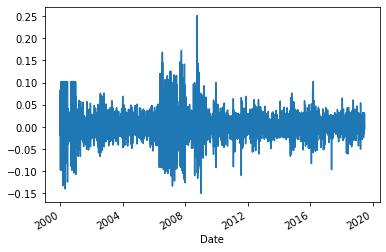

In [5]:
itau['Returns'].plot()
plt.show()

## Return distributions

In order to analyze the probability of outliers in returns, it is helpful to visualize the historical returns of a stock using a histogram.

The outliers on the left tail of the return distribution are what we often want to avoid, as they represent large negative daily returns. Outliers on the right hand side of the distribution are normally particularly good events for the stock such as a positive earnings surprise.

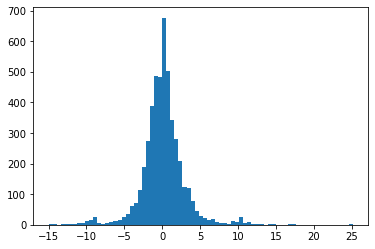

In [6]:
percent_return = itau['Returns']*100
returns_plot = percent_return.dropna()
plt.hist(returns_plot, bins=75)
plt.show()

## First moment: Mu

When we are calculating the average daily return of a stock, we are essentially estimating the first moment ( μ ) of the historical returns distribution.

But what use are daily return estimates to a long-term investor? We can use the formula below to estimate the average annual return of a stock given the average daily return and the number of trading days in a year (typically there are roughly 252 trading days in a year):

Average Annualized Return: ((1 + μ)$^{252})$ - 1


In [7]:
mean_return_daily = np.mean(itau['Returns'])
print("Average Daily Return - {:.2f}%".format(mean_return_daily*100))

mean_return_annualized = ((1+mean_return_daily)**252)-1
print("Average Annualized Return - {:.2f}%".format(mean_return_annualized*100))

Average Daily Return - 0.10%
Average Annualized Return - 29.22%


## Second moment: Variance

Just like we estimated the first moment of the returns distribution above, we can also estimate the second moment, or variance of a return distribution using numpy.

In this case, we will first need to calculate the daily standard deviation ( $σ$ ), or volatility of the returns using np.std(). The variance is simply $σ^2$.

In [8]:
sigma_daily = np.std(itau['Returns'])
print("Daily Volatility - {:.2f} %".format(sigma_daily*100))

variance_daily = sigma_daily**2
print("Daily Variance - {:.2f} %".format(variance_daily*100))

Daily Volatility - 2.83 %
Daily Variance - 0.08 %


In [9]:
sigma_annualized = sigma_daily*np.sqrt(252)
print("Annualized Volatility - {:.2f} %".format(sigma_annualized*100))

variance_annualized = sigma_annualized**2
print("Annualized Variance - {:.2f} %".format(variance_annualized*100))

Annualized Volatility - 44.93 %
Annualized Variance - 20.18 %


## Third moment: Skewness

A negative skew is a right-leaning curve, while positive skew is a left-leaning curve. In finance, we would tend to want positive skewness, as this would mean that the probability of large positive returns is unusually high, and the negative returns are more closely clustered and predictable.

In [10]:
clean_returns = itau['Returns'].dropna()

In [11]:
returns_skewness = skew(clean_returns)
print("Skewness (Normal Distribution would have a skewness much closer to 0): {:.2f}".format(returns_skewness))

Skewness (Normal Distribution would have a skewness much closer to 0): 0.34


## Fourth moment: Kurtosis

Note that this function actually returns the excess kurtosis, not the 4th moment itself. In order to calculate kurtosis, simply add 3 to the excess kurtosis returned by kurtosis().

In [12]:
# Calculate the excess kurtosis of the returns distribution
excess_kurtosis = kurtosis(clean_returns)
print("Excess Kurtosis (Normal Distribution would have an excess kurtosis of 0): {:.2f}".format(excess_kurtosis))

# Derive the true fourth moment of the returns distribution
fourth_moment = excess_kurtosis + 3
print("Kurtosis (Normal Distribution would have a kurtosis of 3): {:.2f}".format(fourth_moment))

Excess Kurtosis (Normal Distribution would have an excess kurtosis of 0): 6.31
Kurtosis (Normal Distribution would have a kurtosis of 3): 9.31


# Statistical tests for normality
In order to truly be confident in judgement of the normality of the stock's return distribution, we will want to use a true statistical test rather than simply examining the kurtosis or skewness.

We can use the shapiro() function from scipy.stats to run a Shapiro-Wilk test of normality on the stock returns. The function will return two values in a list. The first value is the t-stat of the test, and the second value is the p-value. We can use the p-value to make a judgement about the normality of the data. If the p-value is less than or equal to 0.05, we can safely reject the null hypothesis of normality and assume that the data are non-normally distributed.

In [13]:
shapiro_results = shapiro(clean_returns)
print("Shapiro results:", shapiro_results)

# Extract the p-value from the shapiro_results
p_value = shapiro_results[1]
print("P-value: ", p_value) # The p-value is 0, so null hypothesis of normality is rejected. The data are non-normal.

Shapiro results: ShapiroResult(statistic=0.9024592041969299, pvalue=0.0)
P-value:  0.0
